In [3]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from matplotlib import animation
import time
from matplotlib import rcParams
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.family': 'sans-serif',
         'text.usetex': False}
rcParams.update(params)
#%matplotlib notebook

class agg_diff_PDE_1D:
    
    def __init__(self,L,N,dt,diff_H,V,W,init_rho,tmax):
        self.L = L
        self.N = N
        self.V = V
        self.dt = dt
        self.diff_H = diff_H
        self.W = W
        self.dx = L/N
        self.tmax = tmax
        self.chalf = np.linspace(-L,L,int(2*N+1))
        self.cspan = np.linspace(-L + self.dx/2, L - self.dx/2, int(2*N))
        self.rho = [init_rho]
        self.W_matrix = np.array([[W(x - y) for x in self.cspan] for y in self.cspan])
    
    def disc_entropy(self,f):
        return self.diff_H(f) + self.V(self.cspan) + np.dot(self.W_matrix,f)*self.dx
    
    def velocities(self,h):
        return -(h[1:]-h[:-1])/self.dx
    
    def flux(self,v,g):
        zero_vec = np.zeros(len(v))
        F = g[:-1]*np.maximum(v,zero_vec) + g[1:]*np.minimum(v,zero_vec)
        return np.concatenate([[0],F,[0]])
    
    def dpdt(self,t,p):
        h = self.disc_entropy(p)
        F = self.flux(self.velocities(h),p)
        return -(F[1:]-F[:-1])/self.dx
    
    def euler(self):
        t = 0
        while t < self.tmax:
            t += self.dt
            self.rho.append(self.dt*self.dpdt(t,self.rho[-1]) + self.rho[-1])
        return np.array(self.rho)
    
    
    def solve(self):
        solODE = ode(self.dpdt).set_integrator('dopri5') # runge kutta of order 4 (adaptive step size?)
        solODE.set_initial_value(self.rho[-1],0)
        t = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            self.rho.append(solODE.integrate(t))
        return np.array(self.rho)
        

In [10]:
N = 100
L = 6
dt = .08
tmax = 100
dx = L/N
print(dx)
xspan = np.linspace(-L + dx/2, L - dx/2, int(2*N))

def pot_V(x):
    return (x**4/4-x**2/2)*0

def diff_H(f):
    #m,v = 1.5, 0.33
    #return v*f**(m-1)
    return f

def ex_W(x):
    return -np.maximum(1-np.abs(x),0)*0
    #s = 1
    #return -np.exp(-x**2/2/s)/np.sqrt(2*np.pi*s)

init_rho = np.array([1 if abs(i+3.5) < 1 or abs(i-3.5) < 1 else 0 for i in xspan])
#init_rho = np.array([np.exp(-i**2*100) for i in xspan])
xc = .2
#init_rho = 0.1/np.sqrt(2*np.pi*0.2)*np.exp(-(xspan-xc)**2/2/0.2)
#init_rho = np.exp(-xspan**2/2)/np.sqrt(2*np.pi)
#init_rho = 1/np.sqrt(8*np.pi)*(np.exp(-.5*(xspan-2.7)**2) + np.exp(-.5*(xspan +2.7)**2))

solver = agg_diff_PDE_1D(L,N,dt,diff_H,pot_V,ex_W,init_rho,tmax)
rho_sol = solver.solve()

0.06


In [11]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%2== 0]
tspan = np.linspace(0,tmax,len(rho))
fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(0,1.15*np.max(rho)))
line, = ax.plot([], [], lw=1,color = 'black')
def init():
    line.set_data([], [])
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel('$x$')
    ax.set_ylim(0,1.2*np.max(rho))
    ax.text(-L*0.95,np.max(rho),'$W(x) = 0$', color = 'b')
    ax.text(-L*0.95,1.07*np.max(rho),"$H'(\\rho) =\\rho$ ",color = 'b')
    ax.text(-L*0.95,1.14*np.max(rho),"$V(x) = 0$ ",color = 'b')
    return line,
def animate(i):
    x = solver.cspan
    y = rho[i]
    ax.set_title('$t = %.2f$' % tspan[i])
    line.set_data(x, y)
    return line,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= len(rho) - 2)
anim.save('nonlinear_diffusion.mp4', fps=30,dpi = 300)

C:\Users\Carles\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


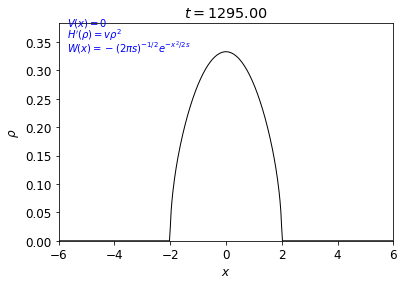

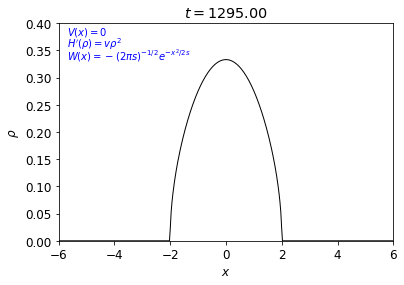

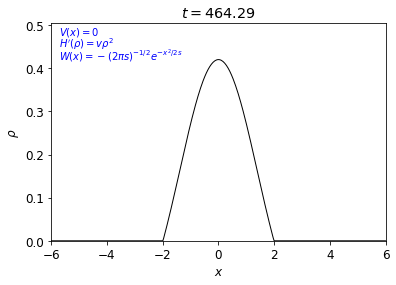

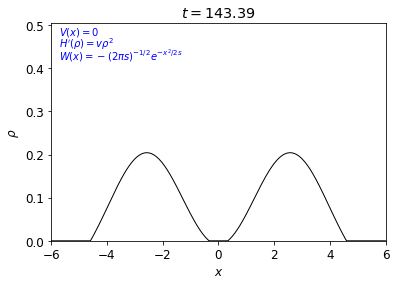

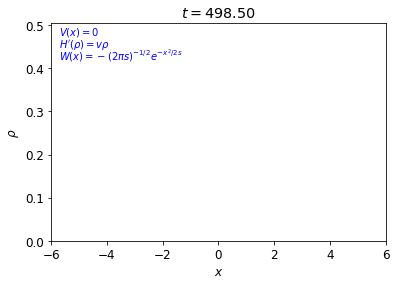

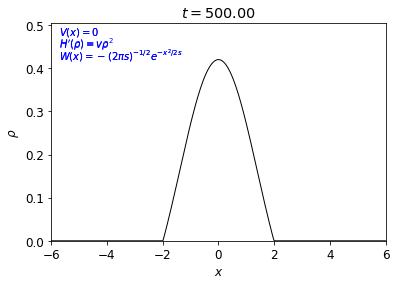

401

In [10]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%5 == 0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-L,L)
ax.set_ylabel('$\\rho$')
ax.set_xlabel('$x$')
ax.set_ylim(0,1.2*np.max(rho))
ax.text(-L*0.95,np.max(rho),'$W(x) = -(2\pi s)^{-1/2}e^{-x^2/2s}$', color = 'b')
ax.text(-L*0.95,1.07*np.max(rho),"$H'(\\rho) =\\rho$ ",color = 'b')
ax.text(-L*0.95,1.14*np.max(rho),"$V(x) = 0$ ",color = 'b')
plt.ion()
fig.show()
fig.canvas.draw()
tspan = np.linspace(0,tmax,len(rho))
for i in range(len(rho)):
    ax.plot(solver.cspan,rho[i],color = 'black',linewidth = 1)
    #ax.plot(np.linspace(-np.sqrt(2),np.sqrt(2),1000),1/np.pi*np.sqrt(2-np.linspace(-np.sqrt(2),np.sqrt(2),1000)**2),color = 'dodgerblue')
    ax.set_title('$t = %.2f$' % tspan[i])
    fig.canvas.draw()
    del ax.lines[:]
#ax.plot(solver.cspan,1/np.pi*np.sqrt(2-solver.cspan**2),color = 'dodgerblue')
ax.plot(solver.cspan,rho[-1],'black',linewidth = 1)
plt.show()
len(rho)